# Final Project

1. Get data 
    * coal plants states, cities
    * death rate in plant city
    * state death rate
1. compare to state avg
1. compare state avg to country avg

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### import data

In [26]:
#data = pd.read_excel('power_plants_and_communities.xls') # data from EPA 2019

In [27]:
#data.rename(columns={'Flag indicating if the plant burned or generated any amount of coal': 'Burned_coal', 'Plant state abbreviation': 'State_abbreviation',
#                    'Plant county name': 'Plant_county', 'State Name': 'State'}, inplace=True) #changes col names to be easier and panda friendly

I need: State_abbreviation, Plant_county,Burned_or_generate_any_coal, state name in new df for easier reading and access
enter into new file for easier data reading

* changes from 326 columns to just 4. 
    * can add more if needed

In [28]:
#new_df = data[['State_abbreviation', 'State', 'Plant_county', 'Burned_coal']]
#print(new_df.head())
#new_df.to_csv('Compressed_power_plant_data.csv', index=False)
 #index false: doesnt add new index column

pd.set_option("display.max.columns", None)

power_plants = pd.read_csv('Compressed_power_plant_data.csv')
print(power_plants.head()) #.head() first five. insert number to read up to x. can use -x to start in reverse.

  State_abbreviation    State    Plant_county Burned_coal
0                 AK   Alaska  Aleutians East         NaN
1                 AL  Alabama          Mobile         Yes
2                 AL  Alabama          Etowah         NaN
3                 AL  Alabama          Walker         Yes
4                 TX    Texas         El Paso         NaN


##### Import Mortality data
* imported from 2022 Country Health rata datasheet

In [29]:
mortality_df = pd.read_excel('2022 County Health Rankings Data.xlsx', sheet_name=5)
mortality_df = mortality_df.rename(columns=mortality_df.iloc[0]).drop(mortality_df.index[0]).reset_index(drop = True) #naming the columns


* should subtract the covid death numbers from numbers to counter the influance

* Realy large file. Perhaps filer it

In [30]:
power_plants.Burned_coal.fillna('No', inplace=True) # replaces the NaN of col with No. NaN already meant no
coal_df = power_plants[power_plants['Burned_coal'] == 'Yes'] # only if plant burns coal
no_coal_df = power_plants[power_plants['Burned_coal'] != 'Yes'] # only if plant does not burns coal


#### Merge mortality with the coal and No-Coal df

In [31]:
merged_no_coal = pd.merge(no_coal_df, mortality_df, left_on= 'Plant_county', right_on='County', suffixes=['_coal_df', '_mortality_df']).drop_duplicates()
non_coal_merge_filtered = merged_no_coal[(merged_no_coal.State_coal_df == merged_no_coal.State_mortality_df) & (merged_no_coal.Plant_county == merged_no_coal.County)]
merged_coal = pd.merge(coal_df, mortality_df, left_on= 'Plant_county', right_on='County', suffixes=['_coal_df', '_mortality_df']).drop_duplicates()
coal_merge_filtered = merged_coal[(merged_coal.State_coal_df == merged_coal.State_mortality_df) & (merged_coal.Plant_county == merged_coal.County)]


coal_merge_1 = coal_merge_filtered[['Plant_county','State_abbreviation', 'Life Expectancy']].copy().dropna().reset_index(drop=True)
non_coal_merge_1 = non_coal_merge_filtered[['Plant_county','State_abbreviation', 'Life Expectancy']].copy().dropna().reset_index(drop=True)


In [32]:
coal_merge_1

,Plant_county,State_abbreviation,Life Expectancy
0,Mobile,AL,74.441642
1,Walker,AL,69.629257
2,Shelby,AL,80.261566
3,Washington,AL,75.287943
4,Washington,MN,81.929043
...,...,...,...
287,Butler,OH,76.356073
288,Huron,MI,77.411977
289,Lee,IA,75.881796
290,Hennepin,MN,80.586347


In [33]:
non_coal_merge_1.head()

,Plant_county,State_abbreviation,Life Expectancy
0,Aleutians East,AK,112.503856
1,Etowah,AL,72.537031
2,El Paso,TX,78.100672
3,El Paso,CO,78.095607
4,Greene,AL,72.860773


###  Calculate the correlation and the statistical significance of the correlation.

In [34]:
from scipy.stats import pearsonr

In [35]:
adjusted_plants = power_plants.filter(items=["State","Plant_county","Burned_coal"])
adjusted_plants = adjusted_plants.rename(columns={"Plant_county": "County"})
adjusted_plants = pd.merge(adjusted_plants, mortality_df)
adjusted_plants = adjusted_plants.drop(adjusted_plants.iloc[:, 7:], axis=1)
adjusted_plants = adjusted_plants.filter(items=["State","County","Burned_coal","Life Expectancy"])
adjusted_plants["Burned_coal"] = adjusted_plants["Burned_coal"].replace({"Yes": 1,"No": 0})
adjusted_plants["Life Expectancy"] = adjusted_plants["Life Expectancy"].astype(float)
adjusted_plants["Burned_coal"] = adjusted_plants["Burned_coal"].astype(float)
adjusted_plants = adjusted_plants.dropna()
r = pearsonr(adjusted_plants["Burned_coal"],adjusted_plants["Life Expectancy"])
print(r)

PearsonRResult(statistic=-0.14358647013408027, pvalue=5.844743082234773e-17)


There is a negative correlation between the existence of a coal power plant and life expectancy. This finding is statistically significant because of the low p-value.

In [36]:
coal_df.columns

Index(['State_abbreviation', 'State', 'Plant_county', 'Burned_coal'], dtype='object')

In [37]:
print(f"There are {power_plants['Plant_county'].count()} power plants across the United states.\
 These plants are spread across all {power_plants['State_abbreviation'].nunique()} states: {power_plants['State_abbreviation'].unique()}.\n\
Of these {power_plants['Plant_county'].count()} power plants, {no_coal_df['State_abbreviation'].count()} are non-coal burning plants\
 and {coal_df['State_abbreviation'].count()} still burning coal")

There are 3467 power plants across the United states. These plants are spread across all 52 states: ['AK' 'AL' 'TX' 'MN' 'LA' 'KY' 'NE' 'NM' 'WA' 'KS' 'AZ' 'SC' 'FL' 'CA'
 'OK' 'AR' 'IL' 'CO' 'CT' 'VT' 'DE' 'MD' 'MO' 'GA' 'HI' 'ID' 'IN' 'NC'
 'IA' 'ME' 'MA' 'MI' 'MS' 'MT' 'WY' 'NV' 'NH' 'NJ' 'NY' 'ND' 'OH' 'PA'
 'RI' 'SD' 'TN' 'UT' 'VA' 'WV' 'WI' 'OR' 'DC' 'PR'].
Of these 3467 power plants, 3120 are non-coal burning plants and 357 still burning coal


#### Filter/calculate mortality rates.
* not sure which columns to calculate on. Need to figure out specific columns to work on

In [38]:
#mortality_df.columns
merged_coal.columns
coal_expectancy_median = coal_merge_filtered['Life Expectancy'].median()
coal_expectancy_mean = coal_merge_filtered['Life Expectancy'].mean()
#did median since it is less effective by large deviated values compared to mean
non_coal_expectancy_median = non_coal_merge_filtered['Life Expectancy'].median()
non_coal_expectancy_mean = non_coal_merge_filtered['Life Expectancy'].mean()

coal_expectancy_std = coal_merge_filtered['Life Expectancy'].std()
non_coal_expectancy_std = non_coal_merge_filtered['Life Expectancy'].std() 

non_coal_expectancy_25th = non_coal_merge_filtered['Life Expectancy'].quantile(.25)
non_coal_expectancy_75th = non_coal_merge_filtered['Life Expectancy'].quantile(.75) 
non_coal_expectancy_50th = non_coal_merge_filtered['Life Expectancy'].quantile(.5) 

non_coal_expectancy_min = non_coal_merge_filtered['Life Expectancy'].min()
non_coal_expectancy_max = non_coal_merge_filtered['Life Expectancy'].max()

coal_expectancy_min = coal_merge_filtered['Life Expectancy'].min()
coal_expectancy_max = coal_merge_filtered['Life Expectancy'].max()

coal_expectancy_25th = coal_merge_filtered['Life Expectancy'].quantile(.25)
coal_expectancy_75th = coal_merge_filtered['Life Expectancy'].quantile(.75) 
coal_expectancy_50th = coal_merge_filtered['Life Expectancy'].quantile(.5) 


In [39]:
#pip install prettytable

In [43]:
from prettytable import PrettyTable

# Create a table object
table = PrettyTable()

# Add columns
table.add_column("Column Name", ["Life Expectancy Mean", "Life Expectancy Median", "Life Expectancy Std",
                                "Life Expectancy Mininum", "Life Expectancy Maximum"])

# Add coal data
table.add_column("Coal Data", [coal_expectancy_mean, coal_expectancy_median, coal_expectancy_std,
                               coal_expectancy_min, coal_expectancy_max])

# Add non-coal data
table.add_column("Non-Coal Data", [non_coal_expectancy_mean, non_coal_expectancy_median, non_coal_expectancy_std,
                                   non_coal_expectancy_min, non_coal_expectancy_max])

# Print the table
print(table)

+-------------------------+--------------------+-------------------+
|       Column Name       |     Coal Data      |   Non-Coal Data   |
+-------------------------+--------------------+-------------------+
|   Life Expectancy Mean  |  76.8781509794726  | 77.56617971893117 |
|  Life Expectancy Median |    76.956256658    |   77.6716711165   |
|   Life Expectancy Std   | 2.9068079886044615 | 3.037456756058826 |
| Life Expectancy Mininum |    66.185033494    |    64.484295722   |
| Life Expectancy Maximum |    89.085612122    |    112.50385595   |
+-------------------------+--------------------+-------------------+


In [44]:
print(f'For Counties with Non-Coal-Powered plants the median life expectancy is {non_coal_expectancy_median} and mean of {non_coal_expectancy_mean} with a standard deviation of {non_coal_expectancy_median}.\
While the minimum is {non_coal_expectancy_min} and max of {non_coal_expectancy_max}. \n\
while the Counties with Coal powered plants is {coal_expectancy_median} and mean of {coal_expectancy_mean} with a standard deviation of {coal_expectancy_std}. \
The minimum life expectancy being {coal_expectancy_min} and a max expectancy of {coal_expectancy_max}')


For Counties with Non-Coal-Powered plants the median life expectancy is 77.6716711165 and mean of 77.56617971893117 with a standard deviation of 77.6716711165.While the minimum is 64.484295722 and max of 112.50385595. 
while the Counties with Coal powered plants is 76.956256658 and mean of 76.8781509794726 with a standard deviation of 2.9068079886044615. The minimum life expectancy being 66.185033494 and a max expectancy of 89.085612122


plots

In [45]:
mortality_col = mortality_df['Life Expectancy']
mortality_col

0       74.835949
1        76.58565
2       77.724729
3        72.86721
4       73.609363
          ...    
3188    76.454661
3189    86.714291
3190    77.001445
3191    78.762004
3192    80.669458
Name: Life Expectancy, Length: 3193, dtype: object

In [46]:
coal_merge_1.head()

,Plant_county,State_abbreviation,Life Expectancy
0,Mobile,AL,74.441642
1,Walker,AL,69.629257
2,Shelby,AL,80.261566
3,Washington,AL,75.287943
4,Washington,MN,81.929043


In [47]:
non_coal_merge_1.head()

,Plant_county,State_abbreviation,Life Expectancy
0,Aleutians East,AK,112.503856
1,Etowah,AL,72.537031
2,El Paso,TX,78.100672
3,El Paso,CO,78.095607
4,Greene,AL,72.860773


In [140]:
states = np.array(coal_merge_1.State_abbreviation)
coal_values = np.array(coal_merge_1['Life Expectancy'])
non_coal_vals = np.array(non_coal_merge_1['Life Expectancy'])
value_lib = {}

for x,y in zip(states, coal_values):
    try:
        if x not in value_lib:
            value_lib.setdefault(x,[]).append(y)
        else:
            value_lib[x].append(y)
    except:
        raise AttributeError

for key in value_lib.keys():
    non_coal_quan_75 = np.quantile([[non_coal_merge_1['Life Expectancy'][i] for i in range(0, len(non_coal_merge_1['State_abbreviation']))\
    if non_coal_merge_1['State_abbreviation'][i] == key]],0.75)
    non_coal_quan_25 = np.quantile([[non_coal_merge_1['Life Expectancy'][i] for i in range(0, len(non_coal_merge_1['State_abbreviation']))\
    if non_coal_merge_1['State_abbreviation'][i] == key]],0.25) 

    coal_quan_75 = np.quantile([[coal_merge_1['Life Expectancy'][i] for i in range(0, len(coal_merge_1['State_abbreviation']))\
    if coal_merge_1['State_abbreviation'][i] == key]],0.75)
    coal_quan_25 = np.quantile([[coal_merge_1['Life Expectancy'][i] for i in range(0, len(coal_merge_1['State_abbreviation']))\
    if coal_merge_1['State_abbreviation'][i] == key]],0.25)

    x = np.mean([non_coal_merge_1['Life Expectancy'][i] for i in range(0, len(non_coal_merge_1['State_abbreviation']))\
    if non_coal_merge_1['State_abbreviation'][i] == key])# adding the non_coal. coal already in lib
    
    value_lib[key]= np.mean(value_lib[key]),x, non_coal_quan_75, non_coal_quan_25, coal_quan_75, coal_quan_25
    # 2nd val should be non coal

dict_df = pd.DataFrame.from_dict(value_lib, orient='index', columns=['coal_mean', 'non_coal_mean', 'non_coal_q75', 'non_coal_q25',\
                                                                     'coal_q75', 'coal_q25'])

In [ ]:
#dict_df

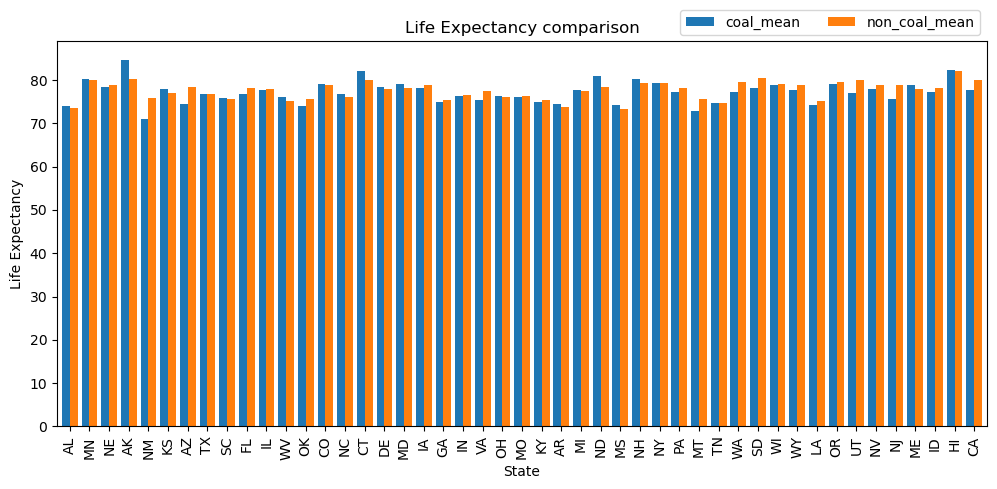

In [141]:
dict_df.plot.bar(y=['coal_mean','non_coal_mean'], ylabel='Life Expectancy', xlabel='State', title='Life Expectancy comparison',\
                figsize=(12,5), width= 0.8 )
plt.legend(bbox_to_anchor=(1.0,1.1), ncol=2)
plt.show()

<Axes: >

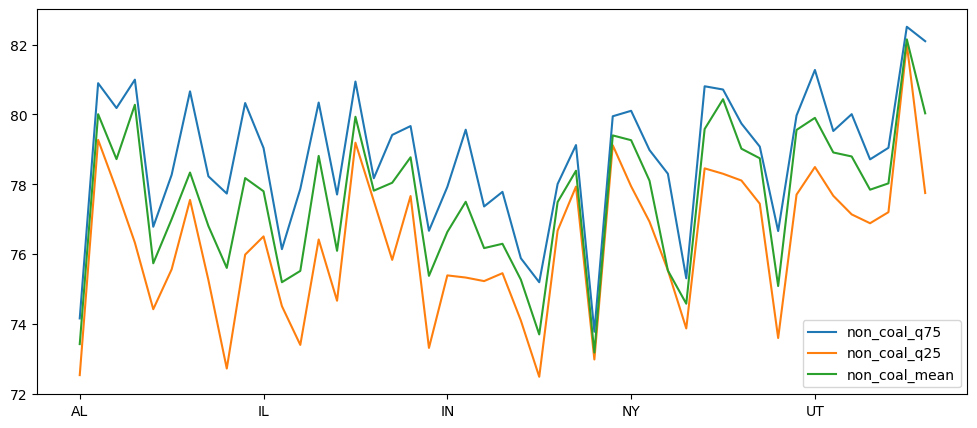

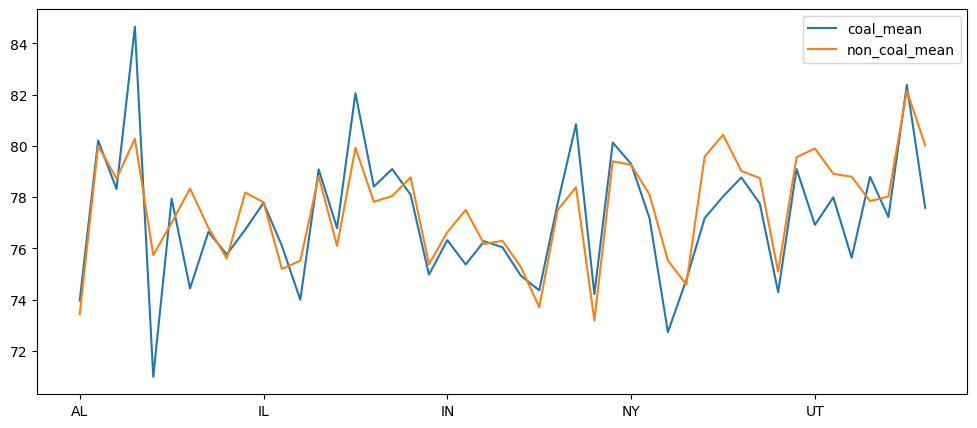

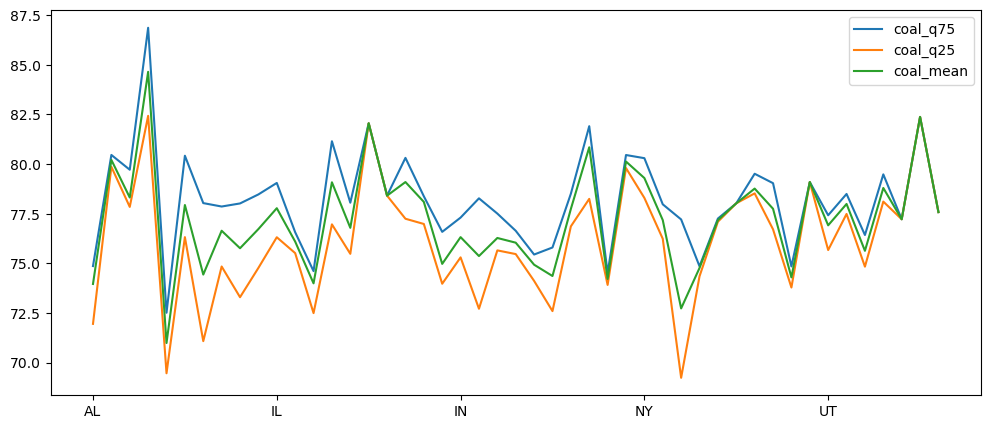

In [162]:
dict_df.plot.line(y=['non_coal_q75', 'non_coal_q25', 'non_coal_mean'],figsize=(12,5))
dict_df.plot.line(y=['coal_mean', 'non_coal_mean'],figsize=(12,5))
dict_df.plot.line(y=['coal_q75', 'coal_q25', 'coal_mean'],figsize=(12,5))

## Sources
Emissions from burning coal
Several principal emissions result from coal combustion:

Sulfur dioxide (SO2), which contributes to acid rain and respiratory illnesses
Nitrogen oxides (NOx), which contribute to smog and respiratory illnesses
Particulates, which contribute to smog, haze, and respiratory illnesses and lung disease
Carbon dioxide (CO2), which is the primary greenhouse gas produced from burning fossil fuels (coal, oil, and natural gas)
Mercury and other heavy metals, which have been linked to both neurological and developmental damage in humans and other animals
Fly ash and bottom ash, which are residues created when power plants burn coal
The U.S. Energy Information Administration estimates (as of October 2022) that in 2021, CO2 emissions from burning coal for energy accounted for about 20% of total U.S. energy-related CO2 emissions and for nearly 60% of total CO2 emissions from the electric power sector.

In the past, fly ash was released into the air through the smokestack, but laws now require that most emissions of fly ash be captured by pollution control devices. In the United States, fly ash and bottom ash are generally stored near power plants or placed in landfills. Pollution leaching from coal ash storage and landfills into groundwater and several large impoundments of coal ash that ruptured are environmental concerns.

#### APA Citation:

U.S. Energy Information Administration . (2022, November 16). Coal explained, Coal and the Environment. Retrieved from U.S. Energy Information Administration : https://www.eia.gov/energyexplained/coal/coal-and-the-environment.php#:~:text=The%20U.S.%20Energy%20Information%20Administration,from%20the%20electric%20power%20sector.


There are about 1,400 coal- and oil-fired electric generating units (EGUs) at 600 power plants covered by these standards. They emit harmful pollutants, including mercury, non-mercury metallic toxics, acid gases, and organic air toxics such as dioxin.

Power plants are currently the dominant emitters of mercury (50 percent), acid gases (over 75 percent) and many toxic metals (20-60 percent) in the United States (see graphic at right).

While newer, and a significant percentage of older power plants already control their emissions of mercury, heavy metals, and acid gases, approximately 40 percent of the current EGUs still do not have advanced pollution control equipment.

The other big sources of mercury have already reduced their emissions.

#### APA Citation

United States Environmental Protection Agency. (2022, July 26). Cleaner Power Plants. Retrieved from Mercury and Air Toxics Standards: https://www.epa.gov/mats/cleaner-power-plants